# Model Creation Notebook

This notebook, we will cover the creation of machine learning models for prediction.

## 1. Import Libraries and Datasets

In [106]:
import pandas as pd
pd.pandas.set_option('display.max_columns', None)

import numpy as np 

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt

import joblib

from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression

# standardize the data
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import mean_squared_error, r2_score, root_mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

In [107]:
# Load the data
train_path = '/Users/manueljohn/Training/github-projects/bike-demand-prediction/artifacts/transformed_data/train_data.csv'
val_path = '/Users/manueljohn/Training/github-projects/bike-demand-prediction/artifacts/transformed_data/validation_data.csv'
test_path = '/Users/manueljohn/Training/github-projects/bike-demand-prediction/artifacts/transformed_data/test_data.csv'

train_df = pd.read_csv(train_path)
val_df = pd.read_csv(val_path)
test_df = pd.read_csv(test_path)

train_df.shape, val_df.shape, test_df.shape

((6984, 40), (852, 40), (852, 40))

In [108]:
def add_rolling_mean(days, train_df, val_df, test_df):

    # Add Rolling Mean for 15 days
    full_df = pd.concat([train_df, val_df, test_df]).reset_index(drop=True)

    daily_data_df = full_df.groupby(['year', 'month', 'day'])['rented_bike_count'].mean().reset_index()

    daily_data_df[f'rolling_avg_{days}'] = daily_data_df['rented_bike_count'].rolling(window = days).mean()
    daily_data_df = daily_data_df.drop(['rented_bike_count'], axis=1)

    train_df = train_df.merge(daily_data_df, on=['year', 'month', 'day']).dropna()
    val_df = val_df.merge(daily_data_df, on=['year', 'month', 'day']).dropna()
    test_df = test_df.merge(daily_data_df, on=['year', 'month', 'day']).dropna()

    return full_df, train_df, val_df, test_df

full_df, train_df, val_df, test_df = add_rolling_mean(15, train_df, val_df, test_df)

train_df.shape, val_df.shape, test_df.shape

((6648, 41), (852, 41), (852, 41))

In [109]:
train_df

,rented_bike_count,hour,temperature,humidity,wind_speed,seasons,holiday,functioning_day,rainfall_class,snowfall_class,visibility_class,solar_radiation_class,year,month,day,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_avg_15
336,217,0,-2.6,73,3.4,3,0,1,0,0,1,0,2017,12,16,5,247.0,296.0,300.0,320.0,451.0,682.0,464.0,354.0,342.0,329.0,325.0,309.0,279.0,221.0,330.0,658.0,285.0,129.0,68.0,69.0,110.0,162.0,241.0,227.0,284.188889
337,302,1,-3.4,76,2.9,3,0,1,0,0,1,0,2017,12,16,5,217.0,247.0,296.0,300.0,320.0,451.0,682.0,464.0,354.0,342.0,329.0,325.0,309.0,279.0,221.0,330.0,658.0,285.0,129.0,68.0,69.0,110.0,162.0,241.0,284.188889
338,228,2,-4.1,73,2.1,3,0,1,0,0,1,0,2017,12,16,5,302.0,217.0,247.0,296.0,300.0,320.0,451.0,682.0,464.0,354.0,342.0,329.0,325.0,309.0,279.0,221.0,330.0,658.0,285.0,129.0,68.0,69.0,110.0,162.0,284.188889
339,129,3,-4.5,71,1.6,3,0,1,0,0,1,0,2017,12,16,5,228.0,302.0,217.0,247.0,296.0,300.0,320.0,451.0,682.0,464.0,354.0,342.0,329.0,325.0,309.0,279.0,221.0,330.0,658.0,285.0,129.0,68.0,69.0,110.0,284.188889
340,80,4,-5.0,70,2.7,3,0,1,0,0,1,0,2017,12,16,5,129.0,228.0,302.0,217.0,247.0,296.0,300.0,320.0,451.0,682.0,464.0,354.0,342.0,329.0,325.0,309.0,279.0,221.0,330.0,658.0,285.0,129.0,68.0,69.0,284.188889
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6979,0,19,23.2,57,2.2,2,0,0,0,0,2,0,2018,9,18,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1293.0,1865.0,2100.0,2232.0,2489.0,1111.250000
6980,0,20,22.6,58,1.4,2,0,0,0,0,2,0,2018,9,18,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1293.0,1865.0,2100.0,2232.0,1111.250000
6981,0,21,22.1,61,1.5,2,0,0,0,0,2,0,2018,9,18,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1293.0,1865.0,2100.0,1111.250000
6982,0,22,21.8,65,0.3,2,0,0,0,0,2,0,2018,9,18,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1293.0,1865.0,1111.250000


## 2. Predictor vs Target Variable

In [73]:
train_df.head()

,rented_bike_count,hour,temperature,humidity,wind_speed,seasons,holiday,functioning_day,rainfall_class,snowfall_class,visibility_class,solar_radiation_class,year,month,day,day_of_week,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_avg_15
336,217,0,-2.6,73,3.4,3,0,1,0,0,1,0,2017,12,16,5,247.0,296.0,300.0,320.0,451.0,682.0,464.0,354.0,342.0,329.0,325.0,309.0,279.0,221.0,330.0,658.0,285.0,129.0,68.0,69.0,110.0,162.0,241.0,227.0,284.188889
337,302,1,-3.4,76,2.9,3,0,1,0,0,1,0,2017,12,16,5,217.0,247.0,296.0,300.0,320.0,451.0,682.0,464.0,354.0,342.0,329.0,325.0,309.0,279.0,221.0,330.0,658.0,285.0,129.0,68.0,69.0,110.0,162.0,241.0,284.188889
338,228,2,-4.1,73,2.1,3,0,1,0,0,1,0,2017,12,16,5,302.0,217.0,247.0,296.0,300.0,320.0,451.0,682.0,464.0,354.0,342.0,329.0,325.0,309.0,279.0,221.0,330.0,658.0,285.0,129.0,68.0,69.0,110.0,162.0,284.188889
339,129,3,-4.5,71,1.6,3,0,1,0,0,1,0,2017,12,16,5,228.0,302.0,217.0,247.0,296.0,300.0,320.0,451.0,682.0,464.0,354.0,342.0,329.0,325.0,309.0,279.0,221.0,330.0,658.0,285.0,129.0,68.0,69.0,110.0,284.188889
340,80,4,-5.0,70,2.7,3,0,1,0,0,1,0,2017,12,16,5,129.0,228.0,302.0,217.0,247.0,296.0,300.0,320.0,451.0,682.0,464.0,354.0,342.0,329.0,325.0,309.0,279.0,221.0,330.0,658.0,285.0,129.0,68.0,69.0,284.188889


In [110]:
class XySplitter:
    def __init__(self, df, target='rented_bike_count'):
        self.df = df
        self.target = target

    def split(self):
        X = self.df.drop(self.target, axis=1)
        y = self.df[self.target]
        return X, y
    

X_train, y_train = XySplitter(train_df).split()
X_val, y_val = XySplitter(val_df).split()
X_test, y_test = XySplitter(test_df).split()

In [75]:
X_train.head(), y_train.head()

(     hour  temperature  humidity  wind_speed  seasons  holiday  \
 336     0         -2.6        73         3.4        3        0   
 337     1         -3.4        76         2.9        3        0   
 338     2         -4.1        73         2.1        3        0   
 339     3         -4.5        71         1.6        3        0   
 340     4         -5.0        70         2.7        3        0   
 
      functioning_day  rainfall_class  snowfall_class  visibility_class  \
 336                1               0               0                 1   
 337                1               0               0                 1   
 338                1               0               0                 1   
 339                1               0               0                 1   
 340                1               0               0                 1   
 
      solar_radiation_class  year  month  day  day_of_week  lag_1  lag_2  \
 336                      0  2017     12   16            5  247.0  2

## 3. Model Selection
We will try out different model and evaluate them in this section

In [76]:
# Set up MLFLow 
import mlflow
from mlflow import MlflowClient
from mlflow.models import infer_signature

client = MlflowClient(tracking_uri="http://127.0.0.1:8080")

# Provide an Experiment description that will appear in the UI
experiment_description = (
"This experiment tracks the performance of differnt models for predicting bike demand."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "bike-demand-forecasting",
    "mlflow.note.content": experiment_description,
}

# Create the Experiment, providing a unique name
produce_apples_experiment = client.create_experiment(
    name="Bike Demand Prediction", tags=experiment_tags
)

In [77]:
all_experiments = client.search_experiments()

print(all_experiments)

[<Experiment: artifact_location='mlflow-artifacts:/688749199831917659', creation_time=1739461880150, experiment_id='688749199831917659', last_update_time=1739461880150, lifecycle_stage='active', name='Bike Demand Prediction', tags={'mlflow.note.content': 'This experiment tracks the performance of differnt '
                        'models for predicting bike demand.',
 'project_name': 'bike-demand-forecasting'}>, <Experiment: artifact_location='mlflow-artifacts:/0', creation_time=1739461875014, experiment_id='0', last_update_time=1739461875014, lifecycle_stage='active', name='Default', tags={}>]


In [78]:
mlflow.set_tracking_uri(uri="http://127.0.0.1:8080")
mlflow.set_experiment("Bike Demand Prediction")

<Experiment: artifact_location='mlflow-artifacts:/688749199831917659', creation_time=1739461880150, experiment_id='688749199831917659', last_update_time=1739461880150, lifecycle_stage='active', name='Bike Demand Prediction', tags={'mlflow.note.content': 'This experiment tracks the performance of differnt '
                        'models for predicting bike demand.',
 'project_name': 'bike-demand-forecasting'}>

### 3.1 Baseline Model

In [79]:
from sklearn.metrics import make_scorer

def availability_error_metric(actual_demand, predicted_demand, weights=None):
    """
    Calculate the Availability Error Metric (AEM) to ensure enough items are available on time.
    
    Parameters:
    - actual_demand: A list or numpy array of actual demand values.
    - predicted_demand: A list or numpy array of predicted demand values.
    - weights: Optional list or numpy array of weights for each time period/item.
    
    Returns:
    - AEM (float): The calculated Availability Error Metric.
    """

    # Ensure inputs are numpy arrays
    actual_demand = np.array(actual_demand)
    predicted_demand = np.array(predicted_demand)
    
    # Calculate the shortfall (only positive differences)
    shortfall = np.maximum(0, actual_demand - predicted_demand)
    
    # If weights are provided, apply them
    if weights is not None:
        weights = np.array(weights)
        weighted_shortfall = shortfall * weights
        aem = np.sum(weighted_shortfall)
    else:
        aem = np.sum(shortfall)
    
    total_demand = np.sum(actual_demand)

    return aem / total_demand

aem_scorer = make_scorer(availability_error_metric, greater_is_better=False)

In [80]:
class ModelTrainerEvaluator:
    def __init__(self, model):
        self.model = model

    def train_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)
        return self.model

    def evaluate_model(self, X, y):
        y_pred = self.model.predict(X)
        y_pred = y_pred.astype(int)

        mse = mean_squared_error(y, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y, y_pred)
        r2 = r2_score(y, y_pred)
        aem = availability_error_metric(y, y_pred)

        metrics = {"mse": mse, 
                   "rmse": rmse,
                   "mae": mae,
                   "r2": r2, 
                   "aem": aem}
        
        return metrics

    def train_evaluate(self, X_train, y_train, X_val, y_val):
        self.train_model(X_train, y_train)
        train_metrics = self.evaluate_model(X_train, y_train)
        val_metrics = self.evaluate_model(X_val, y_val)
        
        return self.model, train_metrics, val_metrics

    def print_metrics(self, metrics):
        for metric, value in metrics.items():
            print(f"{metric}: {value}")

        print("\n")


base_model = LinearRegression()

model_trainer_evaluator = ModelTrainerEvaluator(base_model)
model, train_metrics, val_metrics = model_trainer_evaluator.train_evaluate(X_train,y_train, X_val, y_val)

model_trainer_evaluator.print_metrics(train_metrics)
model_trainer_evaluator.print_metrics(val_metrics)

mse: 39817.095818291215
rmse: 199.54221562940313
mae: 131.01128158844764
r2: 0.9090012042263247
aem: 0.09221982594896641


mse: 65989.52112676056
rmse: 256.8842562843441
mae: 183.77699530516432
r2: 0.865605841077692
aem: 0.14612987210429296




In [83]:
def log_metrics(run_name, model, X_train, y_train, X_val, y_val, tag_info):

    model_trainer_evaluator = ModelTrainerEvaluator(model)
    model, train_metrics, val_metrics = model_trainer_evaluator.train_evaluate(X_train,y_train, X_val, y_val)

    # Start an MLflow run
    with mlflow.start_run(run_name=run_name):
        # Log the hyperparameters
        mlflow.log_metrics({'train_mse': train_metrics['mse'], 
                        'val_mse': val_metrics['mse'], 
                        'train_rmse': train_metrics['rmse'], 
                        'val_rmse': val_metrics['rmse'], 
                        'train_r2': train_metrics['r2'],
                        'val_r2': val_metrics['r2'], 
                        'train_aem': train_metrics['aem'],
                        'val_aem': val_metrics['aem']})

        # Log the loss metric
        mlflow.log_params(model.get_params())

        # Set a tag that we can use to remind ourselves what this run was for
        mlflow.set_tag("Training Info", tag_info)

        # Infer the model signature
        signature = infer_signature(X_train, model.predict(X_train))

        # Log the model
        model_info = mlflow.sklearn.log_model(
            sk_model=model,
            artifact_path="bike_demand_models",
            input_example=X_train,
        )

        return model_info.model_uri

log_metrics(run_name="Baseline Model", 
            model=base_model, X_train=X_train, y_train=y_train, 
            X_val=X_val, y_val=y_val, tag_info="Baseline Linear Regression Model")

🏃 View run Baseline Model at: http://127.0.0.1:8080/#/experiments/688749199831917659/runs/355e05af2e1d47a68c8ccb39c1153fe4
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/688749199831917659


'runs:/355e05af2e1d47a68c8ccb39c1153fe4/bike_demand_models'

### 3.2 Differnet Models

In [84]:
# To track unscaled performance
unscaled_model_metrics = {}

def do_train(alg_name, model, X_train, y_train, X_val, y_val):
    global unscaled_model_metrics

    model_trainer_evaluator = ModelTrainerEvaluator(model)
    model, train_metrics, val_metrics = model_trainer_evaluator.train_evaluate(X_train, y_train, X_val, y_val)

    unscaled_model_metrics[alg_name] = {'train': train_metrics, 
                         'val': val_metrics}

    return model

def check_overfitting(val_error, train_error):
    # Example: Relative Error Difference Threshold
    threshold = 0.1  # 10% threshold
    relative_diff = abs(val_error - train_error) / val_error


    if relative_diff > threshold:
        print(f"The model is likely overfitting. {relative_diff * 100}% Difference.")
        
    else:
        print(f"The model is generalizing well. {relative_diff * 100 }% Difference.")

#### 3.2.1 Without Scaling

In [85]:
# Define data
X_train = X_train
y_train = y_train
X_val = X_val
y_val = y_val

##### 3.2.1.1 Gaussian Naive Bayes

In [86]:
from sklearn.naive_bayes import GaussianNB

model = GaussianNB()
alg_name = "Gaussian-NB"

model = do_train(model=model, alg_name=alg_name, 
                 X_train=X_train, y_train=y_train, 
                 X_val=X_val, y_val=y_val)

train_metrics = unscaled_model_metrics[alg_name]['train']
val_metrics = unscaled_model_metrics[alg_name]['val']

print(f"Traning Metrics: {unscaled_model_metrics[alg_name]['train']} \n")
print(f"Validation Metrics: {unscaled_model_metrics[alg_name]['val']} \n")

check_overfitting(val_error=val_metrics['rmse'], train_error=train_metrics['rmse'])

Traning Metrics: {'mse': 27688.800842358603, 'rmse': 166.3995217612076, 'mae': 83.68501805054152, 'r2': 0.9367194547645968, 'aem': 0.04760004558077504} 

Validation Metrics: {'mse': 145591.64319248826, 'rmse': 381.56473001640006, 'mae': 229.22535211267606, 'r2': 0.7034882796711733, 'aem': 0.19460182925339423} 

The model is likely overfitting. 56.39022460119531% Difference.


In [87]:
log_metrics(run_name=alg_name, 
            model=model, X_train=X_train, y_train=y_train, 
            X_val=X_val, y_val=y_val, tag_info="Gaussian-NB")

🏃 View run Gaussian-NB at: http://127.0.0.1:8080/#/experiments/688749199831917659/runs/a8e2e2063fc248f69ab1398299c96852
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/688749199831917659


'runs:/a8e2e2063fc248f69ab1398299c96852/bike_demand_models'

##### 3.2.1.2 Nearest Neighbour

In [88]:
from sklearn.neighbors import KNeighborsRegressor

model = KNeighborsRegressor(n_neighbors=5)
alg_name = "Nearest-Neigbors"

model = do_train(model=model, alg_name=alg_name, 
                 X_train=X_train, y_train=y_train, 
                 X_val=X_val, y_val=y_val)

train_metrics = unscaled_model_metrics[alg_name]['train']
val_metrics = unscaled_model_metrics[alg_name]['val']

print(f"Traning Metrics: {unscaled_model_metrics[alg_name]['train']} \n")
print(f"Validation Metrics: {unscaled_model_metrics[alg_name]['val']} \n")

check_overfitting(val_error=val_metrics['rmse'], train_error=train_metrics['rmse'])

Traning Metrics: {'mse': 24802.50887484958, 'rmse': 157.48812296439874, 'mae': 87.36928399518652, 'r2': 0.9433158447799102, 'aem': 0.06118522676435583} 

Validation Metrics: {'mse': 56111.40845070423, 'rmse': 236.8784676805898, 'mae': 155.62910798122067, 'r2': 0.8857235904138062, 'aem': 0.09563400814992384} 

The model is likely overfitting. 33.51522217006322% Difference.


In [89]:
log_metrics(run_name=alg_name, 
            model=model, X_train=X_train, y_train=y_train, 
            X_val=X_val, y_val=y_val, tag_info=f"KNN Regressor using 5 neighbour")

🏃 View run Nearest-Neigbors at: http://127.0.0.1:8080/#/experiments/688749199831917659/runs/5d582d842f654e4da873509a78883c12
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/688749199831917659


'runs:/5d582d842f654e4da873509a78883c12/bike_demand_models'

##### 3.2.1.3 SVC

In [90]:
from sklearn.svm import NuSVR

model = NuSVR(degree=5, kernel='poly')
alg_name = "NuSVC"

model = do_train(model=model, alg_name=alg_name, 
                 X_train=X_train, y_train=y_train, 
                 X_val=X_val, y_val=y_val)

train_metrics = unscaled_model_metrics[alg_name]['train']
val_metrics = unscaled_model_metrics[alg_name]['val']

print(f"Traning Metrics: {unscaled_model_metrics[alg_name]['train']} \n")
print(f"Validation Metrics: {unscaled_model_metrics[alg_name]['val']} \n")

check_overfitting(val_error=val_metrics['rmse'], train_error=train_metrics['rmse'])

Traning Metrics: {'mse': 100559.1314681107, 'rmse': 317.11059816428514, 'mae': 209.67539109506617, 'r2': 0.7701801279177902, 'aem': 0.17909720522321917} 

Validation Metrics: {'mse': 177371.91549295775, 'rmse': 421.15545288284915, 'mae': 284.5657276995305, 'r2': 0.6387646251694364, 'aem': 0.23796990337915064} 

The model is likely overfitting. 24.704620112684538% Difference.


In [91]:
log_metrics(run_name=alg_name, 
            model=model, X_train=X_train, y_train=y_train, 
            X_val=X_val, y_val=y_val, tag_info=f"SVC Regressor")

🏃 View run NuSVC at: http://127.0.0.1:8080/#/experiments/688749199831917659/runs/220a2055e1834376b102ac128fadaaac
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/688749199831917659


'runs:/220a2055e1834376b102ac128fadaaac/bike_demand_models'

##### 3.2.1.4 Random Forest

In [ ]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(max_depth=8, 
                              random_state=42
                              )

alg_name = "Random Forest"

model = do_train(model=model, alg_name=alg_name, 
                 X_train=X_train, y_train=y_train, 
                 X_val=X_val, y_val=y_val)

train_metrics = unscaled_model_metrics[alg_name]['train']
val_metrics = unscaled_model_metrics[alg_name]['val']

print(f"Traning Metrics: {unscaled_model_metrics[alg_name]['train']} \n")
print(f"Validation Metrics: {unscaled_model_metrics[alg_name]['val']} \n")

check_overfitting(val_error=val_metrics['rmse'], train_error=train_metrics['rmse'])

Traning Metrics: {'mse': 9910.950511432009, 'rmse': 99.55375689260556, 'mae': 63.459837545126355, 'r2': 0.9773493133294142, 'aem': 0.045265719036726285} 

Validation Metrics: {'mse': 25017.42723004695, 'rmse': 158.16898314791985, 'mae': 98.8169014084507, 'r2': 0.9490495455403639, 'aem': 0.058260281745202216} 

The model is likely overfitting. 37.058609778440086% Difference.


In [93]:
log_metrics(run_name=alg_name, 
            model=model, X_train=X_train, y_train=y_train, 
            X_val=X_val, y_val=y_val, tag_info=f"Random Forest Regressor")

🏃 View run Random Forest at: http://127.0.0.1:8080/#/experiments/688749199831917659/runs/4b831aed44f348248fddc7d83dbbd7b8
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/688749199831917659


'runs:/4b831aed44f348248fddc7d83dbbd7b8/bike_demand_models'

##### 3.2.1.5 Compare Algorithms

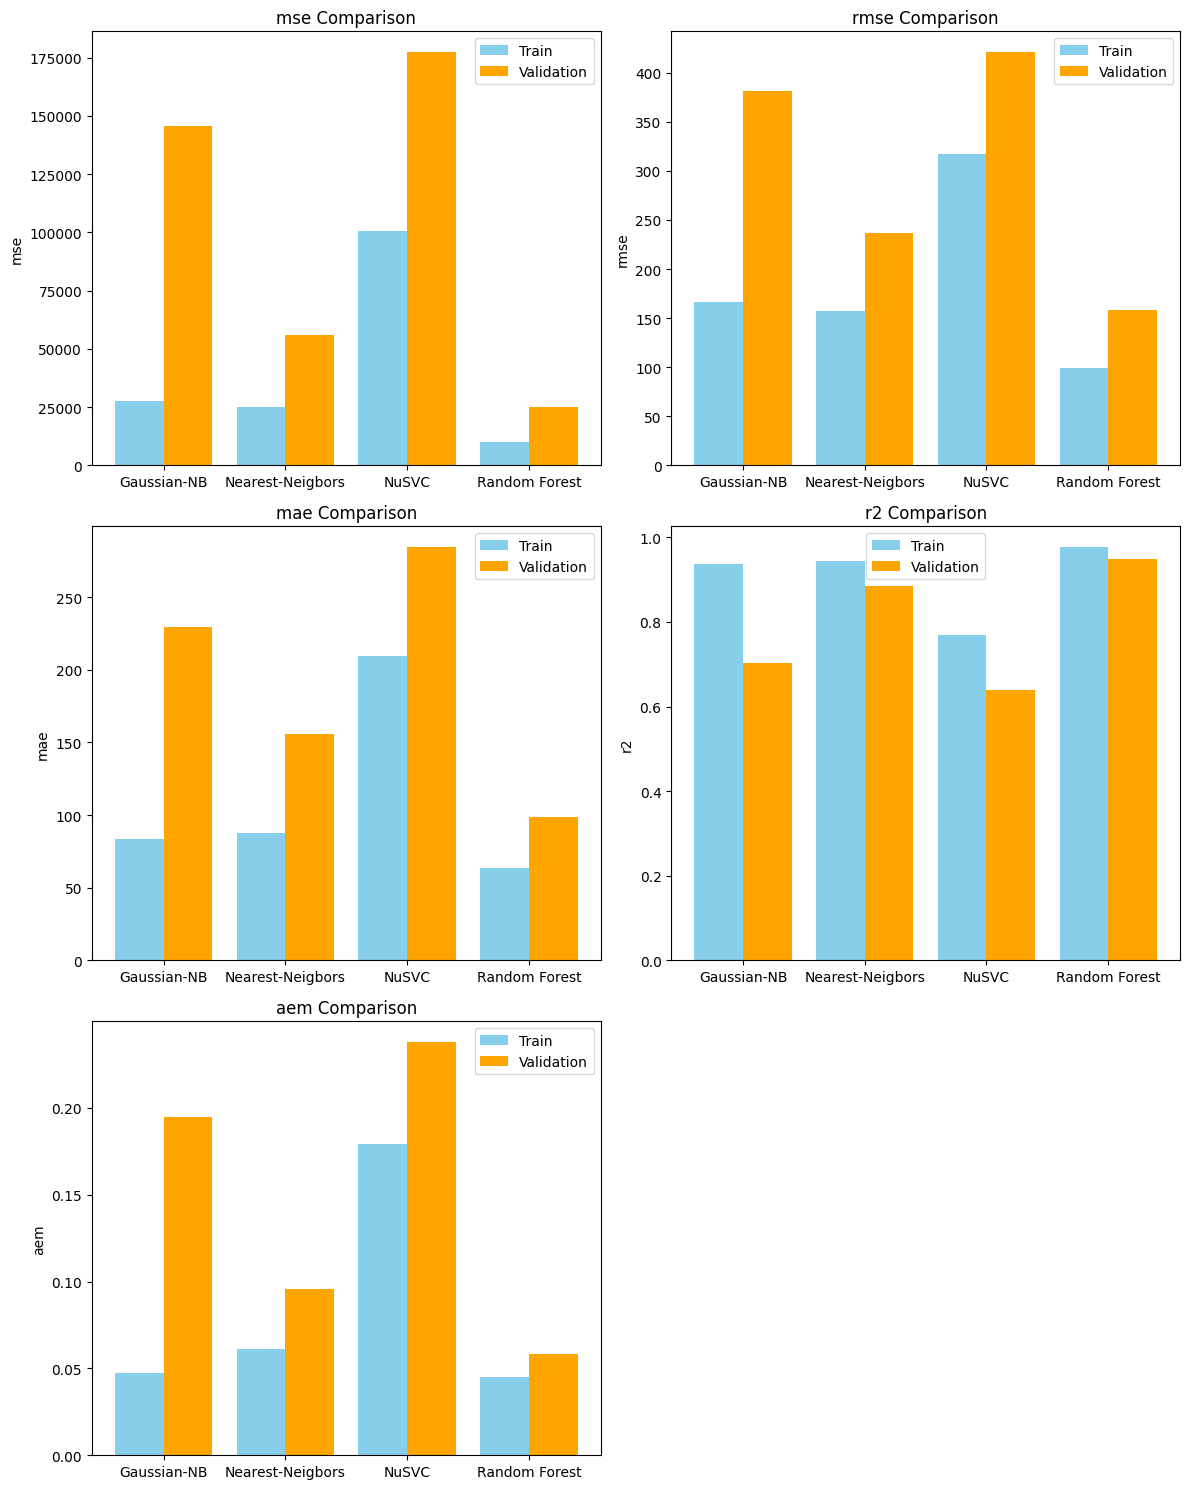

In [94]:
import matplotlib.pyplot as plt

def plot_comparisons(metrics):
    # Prepare data for plotting
    algorithms = list(metrics.keys())
    train_metrics = {metric: [] for metric in metrics['Gaussian-NB']['train'].keys()}
    val_metrics = {metric: [] for metric in metrics['Gaussian-NB']['train'].keys()}

    for algo in algorithms:
        for metric in metrics[algo]['train'].keys():
            train_metrics[metric].append(metrics[algo]['train'][metric])
            val_metrics[metric].append(metrics[algo]['val'][metric])

    # Create subplots for each metric
    fig, axes = plt.subplots(3, 2, figsize=(12, 15))

    # Define the metrics
    metric_labels = list(train_metrics.keys())

    # Plot the metrics
    for i, metric in enumerate(metric_labels):
        ax = axes[i // 2, i % 2]
        ax.bar(np.arange(len(algorithms)) - 0.2, train_metrics[metric], width=0.4, label='Train', color='skyblue', align='center')
        ax.bar(np.arange(len(algorithms)) + 0.2, val_metrics[metric], width=0.4, label='Validation', color='orange', align='center')
        ax.set_xticks(np.arange(len(algorithms)))
        ax.set_xticklabels(algorithms)
        ax.set_title(f'{metric} Comparison')
        ax.set_ylabel(metric)
        ax.legend()

    # Remove empty subplot (since we have 5 metrics and 6 subplots)
    fig.delaxes(axes[2, 1])

    plt.tight_layout()
    plt.show()

plot_comparisons(unscaled_model_metrics)

#### 3.2.2 Feature Importance

                  Feature    Importance
15                  lag_1  8.231233e-01
38                 lag_24  7.203480e-02
0                    hour  2.064091e-02
24                 lag_10  2.031269e-02
16                  lag_2  1.342538e-02
37                 lag_23  1.285747e-02
17                  lag_3  4.551640e-03
10  solar_radiation_class  3.399720e-03
25                 lag_11  3.282380e-03
27                 lag_13  2.579776e-03
19                  lag_5  2.343415e-03
1             temperature  2.237418e-03
29                 lag_15  1.613251e-03
26                 lag_12  1.577443e-03
20                  lag_6  1.401169e-03
18                  lag_4  1.284358e-03
23                  lag_9  1.185259e-03
34                 lag_20  1.077815e-03
39         rolling_avg_15  1.037048e-03
14            day_of_week  1.033829e-03
21                  lag_7  9.853483e-04
2                humidity  9.795784e-04
36                 lag_22  8.104289e-04
35                 lag_21  7.111539e-04


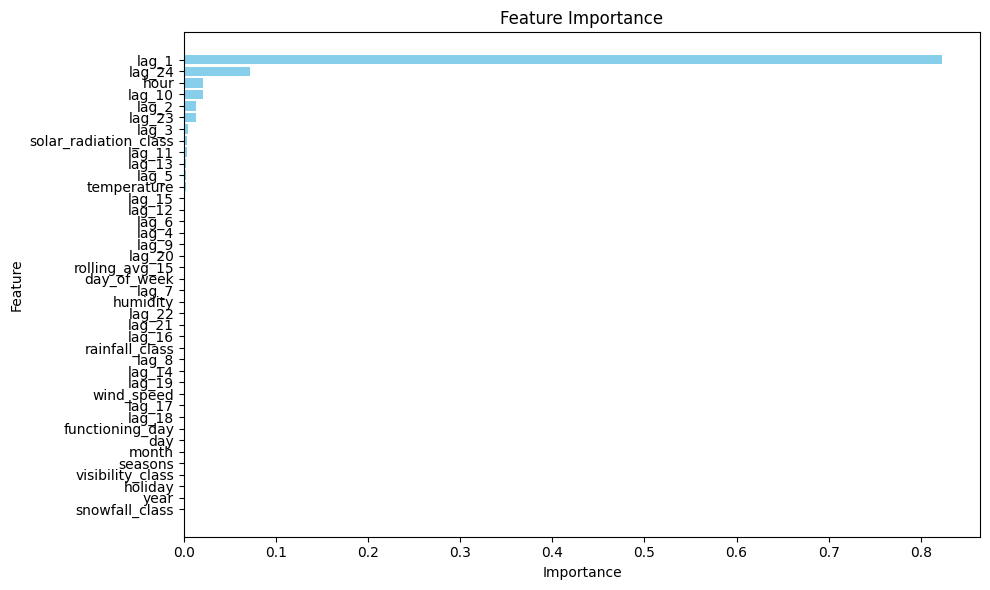

In [95]:
def plot_feature_importance(model, feature_names, top_n=None, sort=True):
    """
    Plots and prints feature importance for a Random Forest model.
    
    Parameters:
    - model: Trained Random Forest model (sklearn.ensemble.RandomForestClassifier or RandomForestRegressor).
    - feature_names: List of feature names corresponding to the training data.
    - top_n: Number of top features to display. If None, displays all features.
    - sort: Whether to sort features by importance in descending order.
    """
    # Get feature importances
    importances = model.feature_importances_
    
    # Create a DataFrame for better readability
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    
    # Sort the features by importance if required
    if sort:
        feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    # Filter top_n features if specified
    if top_n is not None:
        feature_importance_df = feature_importance_df.head(top_n)
    
    # Print the feature importance
    print(feature_importance_df)
    
    # Plot the feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Feature Importance')
    plt.gca().invert_yaxis()  # Invert the y-axis for better visualization
    plt.tight_layout()
    plt.show()

plot_feature_importance(model, X_train.columns)

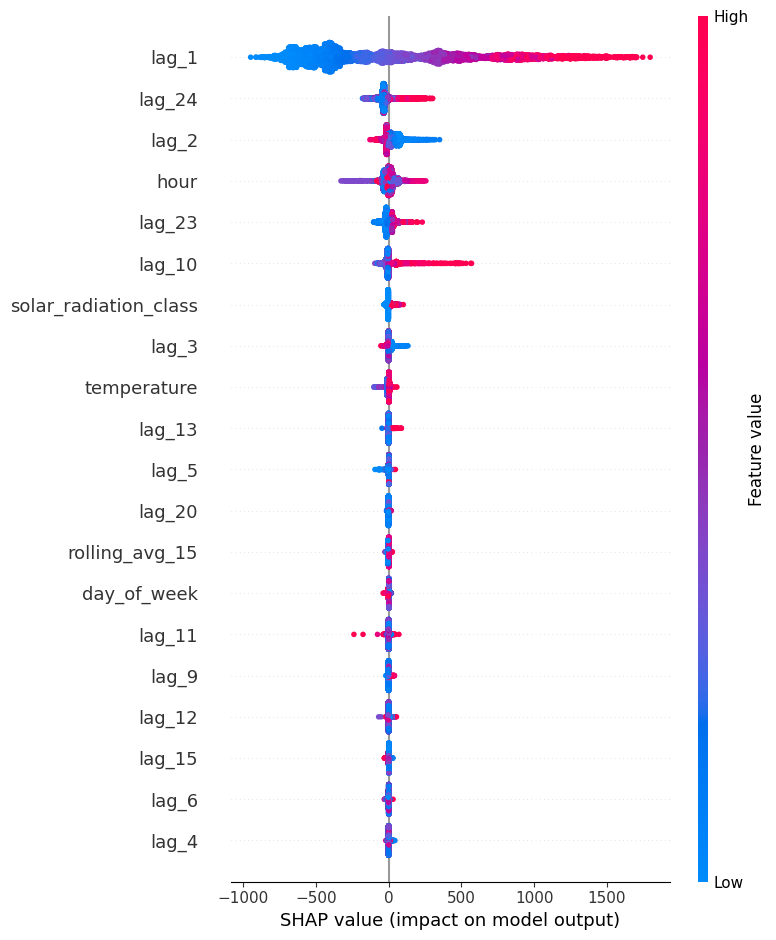

In [96]:
import shap

# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train, y=y_train)

# Summary Plot: Global feature importance
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)

In [97]:
# select top 15 features
importances = model.feature_importances_
    
# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Sort the features by importance if required
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

top_15_features = feature_importance_df['Feature'][:15].to_list()

X_train_new = X_train[top_15_features]
X_val_new = X_val[top_15_features]
X_test_new = X_test[top_15_features]

### 3.3 Hyper Parameter Tuning - Random Forest

In [40]:
def availability_error_metric(actual_demand, predicted_demand, weights=None):
    """
    Calculate the Availability Error Metric (AEM) to ensure enough items are available on time.
    
    Parameters:
    - actual_demand: A list or numpy array of actual demand values.
    - predicted_demand: A list or numpy array of predicted demand values.
    - weights: Optional list or numpy array of weights for each time period/item.
    
    Returns:
    - AEM (float): The calculated Availability Error Metric.
    """

    # Ensure inputs are numpy arrays
    actual_demand = np.array(actual_demand)
    predicted_demand = np.array(predicted_demand)
    
    # Calculate the shortfall (only positive differences)
    shortfall = np.maximum(0, actual_demand - predicted_demand)
    
    # If weights are provided, apply them
    if weights is not None:
        weights = np.array(weights)
        weighted_shortfall = shortfall * weights
        aem = np.sum(weighted_shortfall)
    else:
        aem = np.sum(shortfall)
    
    total_demand = np.sum(actual_demand)

    return aem / total_demand

In [55]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score

def objective(params):
    """
    Objective function to optimize.
    """
    rf = RandomForestRegressor(
        n_estimators=int(params['n_estimators']),
        max_depth=int(params['max_depth']),
        min_samples_split=int(params['min_samples_split']),
        random_state=42
    )
    
    rf.fit(X_train_new, y_train)

    # Calculate AEM for training and validation
    train_preds = rf.predict(X_train_new)
    val_preds = rf.predict(X_val_new)

    train_aem = availability_error_metric(y_train, train_preds)
    val_aem = availability_error_metric(y_val, val_preds)
    
    # Penalize overfitting
    lambda_penalty = 0.5  # Weight for overfitting penalty
    objective_value = val_aem + lambda_penalty * abs(train_aem - val_aem)
    
    # Minimize the negative accuracy
    return {'loss': objective_value, 'status': STATUS_OK}

# Define the search space
space = {
    'n_estimators': hp.quniform('n_estimators', 50, 300, 10),
    'max_depth': hp.quniform('max_depth', 5, 50, 5),
    'min_samples_split': hp.quniform('min_samples_split', 2, 20, 1),

}

# Run the optimization
trials = Trials()
best = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,  # Tree-structured Parzen Estimator
    max_evals=20,     # Number of iterations
    trials=trials,
    rstate=np.random.default_rng(42)  # For reproducibility
)

# Print the best parameters
print("Best Parameters:")
print(best)

# Convert best parameters back to their correct types
best_params = {
    'n_estimators': int(best['n_estimators']),
    'max_depth': int(best['max_depth']),
    'min_samples_split': int(best['min_samples_split']),
}

print("Converted Best Parameters:")
print(best_params)

100%|██████████| 20/20 [22:18<00:00, 66.91s/trial, best loss: 0.06051082080992197] 
Best Parameters:
{'max_depth': np.float64(10.0), 'min_samples_split': np.float64(13.0), 'n_estimators': np.float64(250.0)}
Converted Best Parameters:
{'n_estimators': 250, 'max_depth': 10, 'min_samples_split': 13}


In [98]:
model = RandomForestRegressor(max_depth=7, min_samples_split=13, n_estimators=250, random_state=42)

alg_name = "Random Forest Best"

model = do_train(model=model, alg_name=alg_name, 
                 X_train=X_train_new, y_train=y_train, 
                 X_val=X_val_new, y_val=y_val)

train_metrics = unscaled_model_metrics[alg_name]['train']
val_metrics = unscaled_model_metrics[alg_name]['val']

print(f"Traning Metrics: {unscaled_model_metrics[alg_name]['train']} \n")
print(f"Validation Metrics: {unscaled_model_metrics[alg_name]['val']} \n")

check_overfitting(val_error=val_metrics['rmse'], train_error=train_metrics['rmse'])

Traning Metrics: {'mse': 15225.45487364621, 'rmse': 123.39147001979597, 'mae': 77.3023465703971, 'r2': 0.9652034376155638, 'aem': 0.054965983236403844} 

Validation Metrics: {'mse': 32350.49178403756, 'rmse': 179.8624246029102, 'mae': 112.73122065727699, 'r2': 0.9341150373604448, 'aem': 0.06477587709415307} 

The model is likely overfitting. 31.39674932537328% Difference.


                  Feature  Importance
0                   lag_1    0.835080
1                  lag_24    0.074538
3                  lag_10    0.020984
2                    hour    0.020404
5                  lag_23    0.013498
4                   lag_2    0.013207
6                   lag_3    0.004589
7   solar_radiation_class    0.003309
8                  lag_11    0.002996
9                  lag_13    0.002453
10                  lag_5    0.002226
11            temperature    0.001843
12                 lag_15    0.001785
14                  lag_6    0.001712
13                 lag_12    0.001376


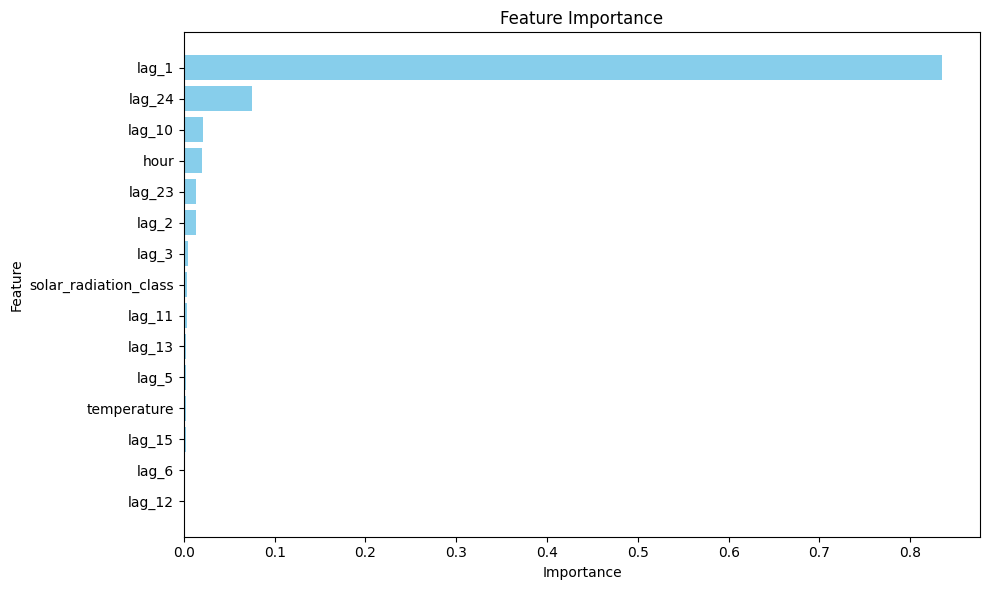

In [42]:
plot_feature_importance(model, X_train_new.columns)

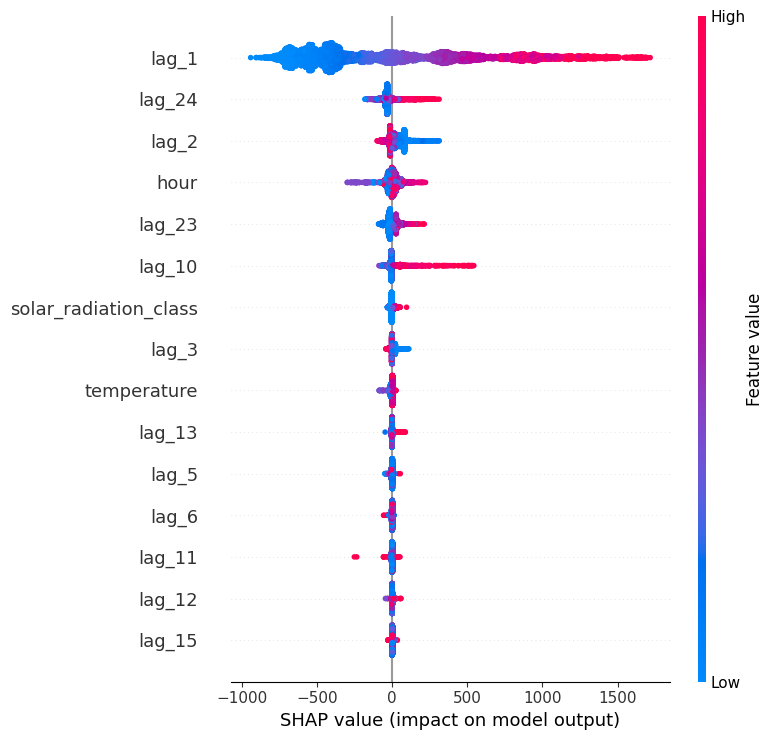

In [44]:
# Initialize SHAP explainer
explainer = shap.TreeExplainer(model)

# Calculate SHAP values
shap_values = explainer.shap_values(X_train_new, y=y_train)

# Summary Plot: Global feature importance
shap.summary_plot(shap_values, X_train_new, feature_names=X_train_new.columns)

In [100]:
log_metrics(model=model, run_name="Best RF",
            X_train=X_train_new, y_train=y_train, 
            X_val=X_val_new, y_val=y_val, 
            tag_info="Hyper Tuned Random Forest")

🏃 View run Best RF at: http://127.0.0.1:8080/#/experiments/688749199831917659/runs/5402220f2ad2490eaecc11cc80ab0f9f
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/688749199831917659


'runs:/5402220f2ad2490eaecc11cc80ab0f9f/bike_demand_models'